In [1]:
%%time
# Imports
from utils import *

CPU times: total: 1.16 s
Wall time: 5.19 s


File-Reading

In [2]:
%%time

# Get start time
start = time.perf_counter()

# File-Reading
path = os.path.join(os.getcwd() , out_file) # from utils
user = []
ts = []
ca = []
tweets = []
mentions = []
coord = []
country = []

with open(path , 'r' , encoding='utf-8') as in_file:
    csv_reader = csv.reader(in_file , delimiter = "|")
    for line in csv_reader:
        user.append(line[0])
        ts.append(line[1])
        ca.append(line[2])
        tweets.append(line[3])
        mentions.append(line[4])
        coord.append(line[5])
        country.append(line[6])

CPU times: total: 24 s
Wall time: 24.1 s


Checking for disparity between timestamp column and created_at column

In [3]:
%%time

ts_convert = [datetime.datetime.fromtimestamp(int(dt)//1000) for dt in ts]

# Make DF
twt_time_df = pd.DataFrame(
    list(zip(ts_convert , ca)) , 
    columns = ['ts' , 'created_at']
)

# twt_time_df['ts'] = pd.to_datetime(twt_time_df['ts'].apply(lambda x : x[:-3]) , unit = 's')

# Remove unnecessary rows - Instate a check here. Removed rows should be ~322
twt_time_df = twt_time_df[twt_time_df['created_at']!= "None"]
# Remove Time Zone Stamp
twt_time_df['created_at'] = twt_time_df['created_at'].apply(lambda x : str(x)[:19] + ' ' + str(x)[-4:])

twt_time_df['created_at'] = pd.to_datetime(twt_time_df['created_at'])
# 3 min 31 sec

twt_time_df['diff'] = (twt_time_df['ts'] - twt_time_df['created_at'])/pd.Timedelta(hours = 1)

CPU times: total: 3min 6s
Wall time: 3min 6s


In [4]:
print(twt_time_df['diff'].nunique())
print(twt_time_df.head(2))
print(twt_time_df.tail(2))

1
          ts          created_at  diff
0 2022-06-01 2022-05-31 23:00:00   1.0
1 2022-06-01 2022-05-31 23:00:00   1.0
                          ts          created_at  diff
15040707 2022-06-30 23:59:59 2022-06-30 22:59:59   1.0
15040708 2022-06-30 23:59:59 2022-06-30 22:59:59   1.0


In [5]:
del twt_time_df

One can hazard a guess as to why there is this consistent time difference:<br/>
Between March and October of a given year, UK Time or British Standard Time is 1 hour ahead of UTC. <br/>
Therefore, there seems to be a 1 hour lag in the UTC timestamps, as the tweets were scraped between Jun 1st and Jun 30th **UK time** 

# **01 - BASIC STATS**
### **Question - 1**

In [6]:
%%time
# Remove None tweets - there are a few
tweets_non_null = [tweet for tweet in tweets if tweet!="None"]
tweets_null = [tweet for tweet in tweets if tweet=="None"]

# Duplicate Identification
tweets_non_null_2 = np.sort(np.array(tweets_non_null))
duplicates = tweets_non_null_2[:-1][tweets_non_null_2[1:]==tweets_non_null_2[:-1]] # https://stackoverflow.com/questions/11528078/determining-duplicate-values-in-an-array

# Question - 1
print(f'The total number of tweets is {len(set(tweets_non_null))} with {len(set(duplicates))} occupying {len(duplicates)} places. {len(tweets_null)} records do not have tweet ID')

The total number of tweets is 15033548 with 5666 occupying 6839 places. 322 records do not have tweet ID
CPU times: total: 8.8 s
Wall time: 8.82 s


### **Question - 2**

CPU times: total: 1min 33s
Wall time: 1min 33s
Compiler : 266 ms


(19144.0, 19173.0)

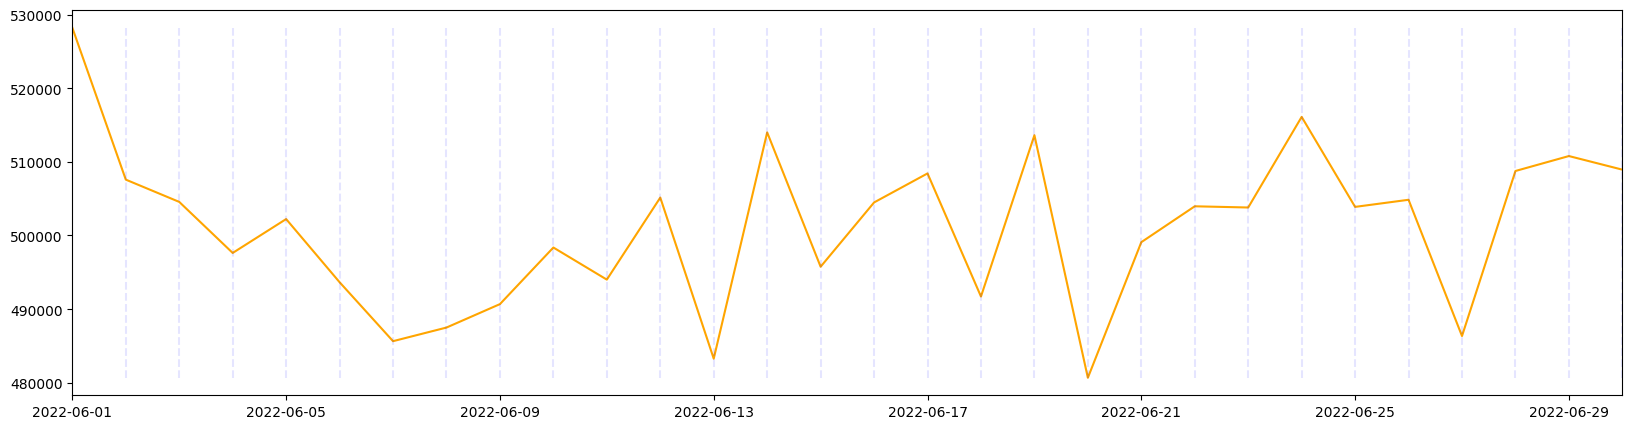

In [7]:
%%time
ts_convert = [datetime.datetime.fromtimestamp(int(dt)/1000) for dt in ts]

twt_df = pd.DataFrame(list(zip(user , ts_convert , tweets)) , columns = ['user' , 'ts' , 'tweet_id'])
twt_df = twt_df[twt_df['tweet_id']!="None"].drop_duplicates()

# QC
assert len(twt_df) == len(set(tweets_non_null)) , "length of db does not match"

# Correctness Check - one tweet cannot have more than 1 author or less than 1 author
assert twt_df.groupby('tweet_id').agg(num_auth = ('user','nunique')).reset_index().sort_values('num_auth' , ascending = False).iloc[0]['num_auth'] == 1 , 'tweet cannot have moree than one author'

# Create a date column
twt_df['ts_day'] = pd.to_datetime(twt_df['ts']).dt.date # https://www.geeksforgeeks.org/how-to-convert-datetime-to-date-in-pandas/

# Group at day level
twt_daily = twt_df.groupby('ts_day').agg(num_tweets = ('tweet_id','nunique'))

# Plot
fig , ax = plt.subplots(figsize = (20 , 5))
ax.plot(twt_daily['num_tweets'] , color = 'orange');
ax.vlines(
    twt_daily.index , 
    ymin = min(twt_daily['num_tweets']) , 
    ymax = max(twt_daily['num_tweets']) ,
    color = 'blue' ,
    alpha = 0.1 ,
    ls = '--'
);
plt.xlim(min(twt_daily.index) , max(twt_daily.index));
# plt.xticks(rotation = 90);
# plt.xticks(twt_daily.index);

**Comments**:<br/>
Tweets seem to be falling slightly on Mondays/ Tuesdays, which sort of makes sense as people resume work after the weekend.

### **Question - 3**

2.75
Correlation coefficient is 0.6266438946457623
CPU times: total: 31 s
Wall time: 31.1 s


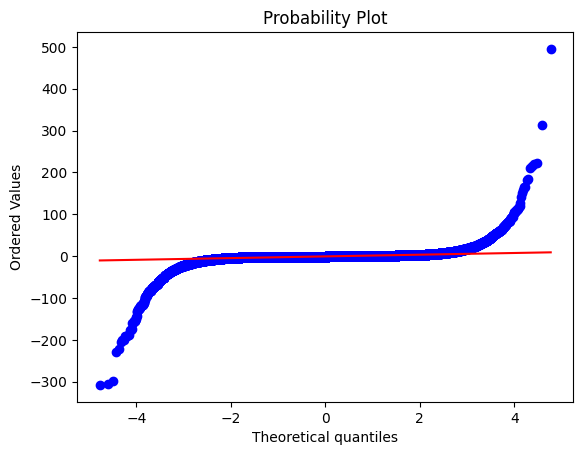

In [8]:
%%time
# Create a weekday-or-not column
twt_df['weekday'] = np.where(pd.to_datetime(twt_df['ts']).dt.day_of_week <= 4 , 1 , 0)

# Should be close to 22/8 = 2.75 if there's no real difference in the amount of tweets between weekends and weekdays
print(np.round(len(twt_df[twt_df['weekday'] == 1])/len(twt_df[twt_df['weekday'] == 0]) , 2))

# More Rigourous Testing is necessary
hypo_test_df = twt_df.pivot_table(
    index = ['user'] , 
    columns = ['weekday'] , 
    values = ['tweet_id' , 'ts_day'] , 
    aggfunc = 'nunique'
    ).reset_index().fillna(0)

# Reset the  column names
hypo_test_df.columns = ['user' , 'weekends' , 'weekdays' , 'weekend_tweets' , 'weekday_tweets']

# Collect average weekend and weekday tweets at user level
hypo_test_df['avg_weekend_tweets'] = hypo_test_df['weekend_tweets']/hypo_test_df['weekends']
hypo_test_df['avg_weekday_tweets'] = hypo_test_df['weekday_tweets']/hypo_test_df['weekdays']

hypo_test_df.fillna(0 , inplace = True)

# We will test if this difference is normal(-ish); that will allow us to conduct t-tests on the data 
hypo_test_df['mean_diff'] = hypo_test_df['avg_weekend_tweets'] - hypo_test_df['avg_weekday_tweets']


(osm, osr), (slope, intercept, r) = scipy.stats.probplot(hypo_test_df['mean_diff'] , plot = plt);
print(f'Correlation coefficient is {r}')


This doesn't look to be very normal. However, let us remind ourselves that with large N, t-test is not _that_ sensitive to non-normal data <br/>
Because of such large data, CLT will help in us being able to use a t-test! <br/>
**Reference**: https://thestatsgeek.com/2013/09/28/the-t-test-and-robustness-to-non-normality/


CPU times: total: 6.67 s
Wall time: 6.65 s


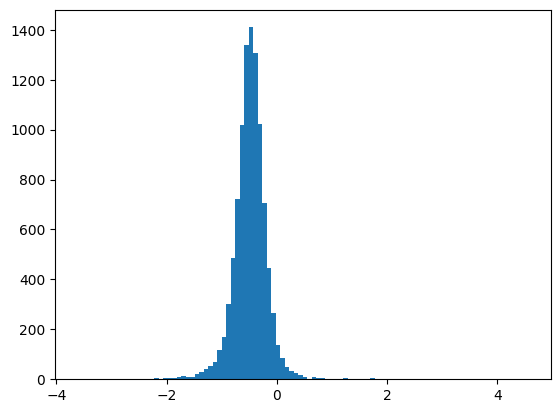

In [9]:
%%time
# Simulate CLT
X = np.array(hypo_test_df['mean_diff'])

sample_size = 100

N = 10000

collect = []

for _ in range(N):
    sample = [np.random.choice(X) for i in range(100)]
    sample_mean = np.mean(sample)
    collect.append(sample_mean)

fig , ax = plt.subplots()

freq , bins , patches = ax.hist(collect , bins = 100);

# Lo and behold, it is normal - we can use a paired ttest (scipy.stats.ttest_rel)


In [10]:
%%time
# Standardize the data
avg_weekday_twt = (np.array(hypo_test_df['avg_weekday_tweets']) - np.mean(np.array(hypo_test_df['avg_weekday_tweets'])))/np.std(np.array(hypo_test_df['avg_weekday_tweets']))
avg_weekdend_twt = (np.array(hypo_test_df['avg_weekend_tweets']) - np.mean(np.array(hypo_test_df['avg_weekend_tweets'])))/np.std(np.array(hypo_test_df['avg_weekend_tweets']))

# Set up the Hypothesis test
# H0: There is not difference between the means
# Paired T Test
scipy.stats.ttest_rel(avg_weekday_twt , avg_weekdend_twt)

CPU times: total: 31.2 ms
Wall time: 33 ms


Ttest_relResult(statistic=2.654590994409255e-14, pvalue=0.9999999999999788)

**Such a high p-value says:**
1. There is definitely not enough evidence to reject the Null Hypothesis that the two means are equal.
2. The two datasets are most likely highly correlated; a correlation test would likely yield a very high coefficient

In [11]:
%%time
scipy.stats.pearsonr(avg_weekday_twt , avg_weekdend_twt)

CPU times: total: 15.6 ms
Wall time: 22 ms


PearsonRResult(statistic=0.7548022023741843, pvalue=0.0)

CPU times: total: 31.2 ms
Wall time: 39 ms


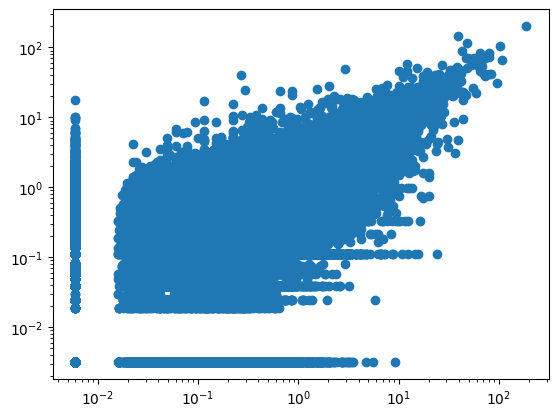

In [12]:
%%time
plt.scatter(avg_weekday_twt , avg_weekdend_twt);
plt.xscale('log');
plt.yscale('log');

**They appear to be roughly correlated, albeit not to a great degree (75%)**

### **Question - 4**

In [13]:
%%time
day_df = pd.DataFrame(
    [
        [0 , 'Mon'],
        [1 , 'Tue'],
        [2 , 'Wed'],
        [3 , 'Thu'],
        [4 , 'Fri'],
        [5 , 'Sat'],
        [6 , 'Sun'],
    ] ,
    columns = ['day' , 'dayofweek']
)

CPU times: total: 0 ns
Wall time: 999 µs


In [14]:
%%time
twt_df['hour'] = twt_df['ts'].dt.hour
twt_df['day'] = twt_df['ts'].dt.day_of_week
twt_df = twt_df.merge(day_df , on = 'day' , how = 'inner')

CPU times: total: 5.92 s
Wall time: 6.09 s


In [15]:
%%time
twt_df_hr = twt_df.groupby(['hour' , 'dayofweek']).agg(num_tweets = ('tweet_id','nunique')).reset_index()

CPU times: total: 13.5 s
Wall time: 13.5 s


In [16]:
%%time
# Check
twt_df_hr.sum().num_tweets

CPU times: total: 0 ns
Wall time: 5 ms


15033548

In [17]:
%%time
twt_df_hr_only = twt_df_hr.groupby('hour').agg(num_tweets_avg = ('num_tweets' , np.mean))

CPU times: total: 15.6 ms
Wall time: 16.9 ms


CPU times: total: 46.9 ms
Wall time: 40 ms


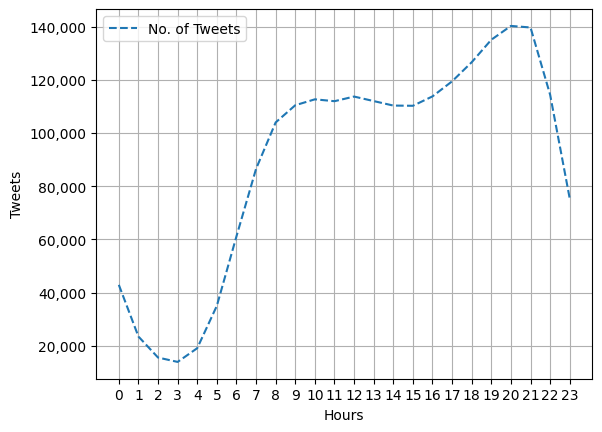

In [18]:
%%time
fig , ax = plt.subplots()

ax.plot(twt_df_hr_only , ls = '--' , label = 'No. of Tweets');
plt.xticks(twt_df_hr_only.index);
ax.grid();
ax.legend(loc = 'best');
ax.set_xlabel('Hours');
ax.set_ylabel('Tweets');
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#https://stackoverflow.com/questions/51734218/formatting-y-axis-matplotlib-with-thousands-separator-and-font-size

**Comment on Pattern** <br/>
Starting from 12 midnight, we see a decline in the number of tweets as more and more people go to bed. This number starts picking up after 2 AM - 3AM as people start getting up (remember there are a couple of timezones captured in this data). The number climbs sharply till about 8 AM, which is likely when most users clock in to their daily work/ school, (or start commuting to work/ school etc). Tweets stay plateaued at this range till around 3 PM, from where it starts hiking upwards again - people are liekly leaving work/ school at this time. Number continues to increase until roughly 10 PM at night, which is when we see a sharp decline, likely due to users retiring for the day/ going to bed. <br/>
As a bonus, let's look at the pattern over the days separately instead of averaging them

In [19]:
%%time
twt_df_2 = twt_df.copy()
twt_df_2['day_hr'] = twt_df_2['day']*100+twt_df_2['hour']
twt_df_3 = twt_df_2.groupby('day_hr').agg(num_tweets = ('tweet_id' , 'nunique')).reset_index()
twt_df_3['day_hr'] = twt_df_3['day_hr'].astype('str').str.zfill(4)

CPU times: total: 17.3 s
Wall time: 20.1 s


CPU times: total: 141 ms
Wall time: 159 ms


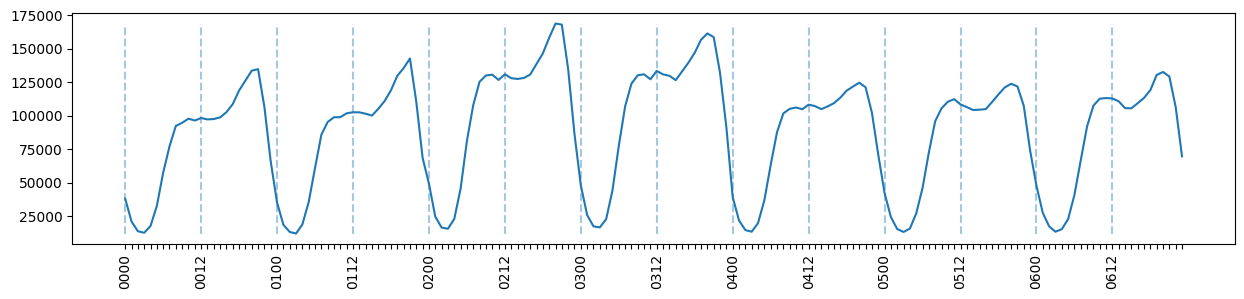

In [20]:
%%time
fig , ax = plt.subplots(figsize = (15 , 3))
ax.plot(twt_df_3.day_hr , twt_df_3.num_tweets);
#ax.grid();

plt.xticks(rotation = 90);

every_nth = 12
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

ax.vlines(
    twt_df_3.day_hr[::12] , 
    ymin = twt_df_3.num_tweets.min() , 
    ymax = twt_df_3.num_tweets.max() ,
    alpha = 0.4 , ls = '--');

**It seems like although the hourly pattern is mostly preserved in the number of tweets, Wednesdays and Thursdays see on average the highest volume of tweets** 

# **02 - USERS**
### **Question - 1**

In [21]:
%%time
twt_df_usr = twt_df.groupby('user').agg(num_twt = ('tweet_id' , 'nunique')).reset_index()

CPU times: total: 23.4 s
Wall time: 23.4 s


CPU times: total: 141 ms
Wall time: 138 ms


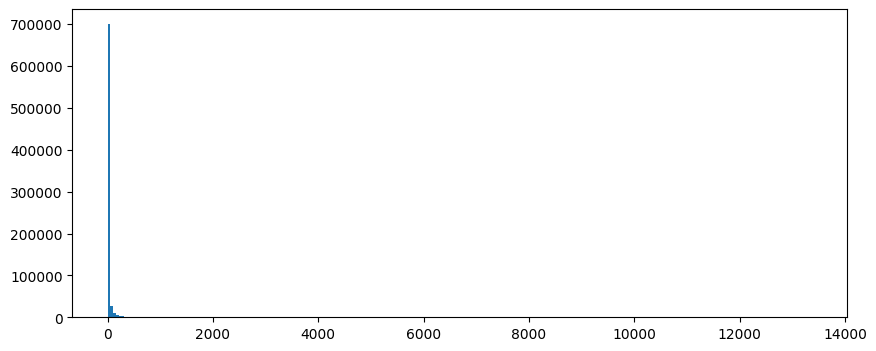

In [22]:
%%time
fig , ax = plt.subplots(figsize = (10 , 4));

freq , bins , patches = ax.hist(twt_df_usr.num_twt , bins = 250);

That's not very enlightening. Let's see if we can do better manually!

In [23]:
%%time
twt_df_usr_2 = twt_df_usr.groupby('num_twt').agg(users = ('user' , 'nunique')).reset_index()

# Applying log-log transformations on both
twt_df_usr_2['log_users'] = np.log10(twt_df_usr_2['users'])
twt_df_usr_2['log_twt'] = np.log10(twt_df_usr_2['num_twt'])

CPU times: total: 609 ms
Wall time: 638 ms


CPU times: total: 15.6 ms
Wall time: 13 ms


Text(0, 0.5, 'log10(number of users)')

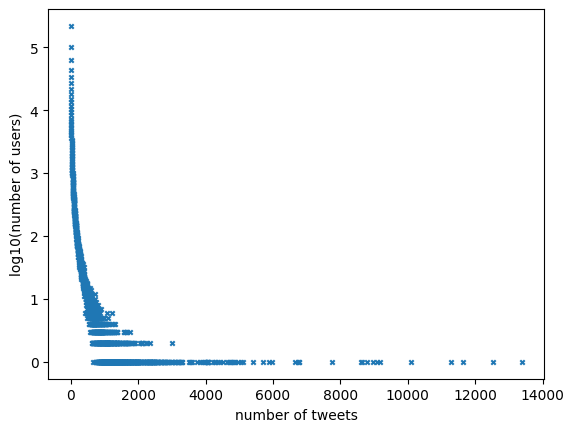

In [24]:
%%time
fig , ax = plt.subplots()
ax.scatter(twt_df_usr_2['num_twt'] , twt_df_usr_2['log_users'] , s = 10 , marker = 'x');
ax.set_xlabel('number of tweets');
ax.set_ylabel('log10(number of users)');

We see that this plot roughly agrees with the histogram. It helps us understand that the majority of users tweet between $1$ and $2000$ times (we will return to quantifying this a little later). <br/>
However, there are *some* users who have tweeted over $10,000$ times, with the top user (by volume of tweets) having tweeted $13,376$ times! <br/>
Seeing that there are 30 days in our dataset, this user must have tweeted $\frac{13376}{30 \cdot 24} = 18.6$ times per hour, every hour of every day of the month. This is a bit ludicrous. <br/>

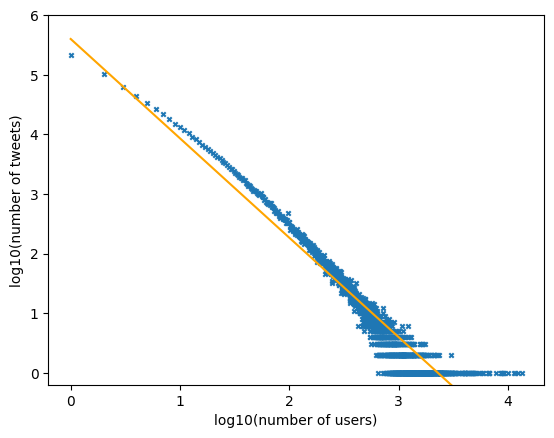

In [25]:
fig , ax = plt.subplots()
ax.scatter(twt_df_usr_2['log_twt'] , twt_df_usr_2['log_users'] , s = 10 , marker = 'x');
ax.set_xlabel('log10(number of users)');
ax.set_ylabel('log10(number of tweets)');

# Eyeballing the equation of the line
x = np.linspace(0 , 4)
y = (-5/3)*x + 5.6
ax.plot(x , y , color = 'orange')
plt.ylim(-0.2 , 6);

<AxesSubplot: xlabel='log_twt', ylabel='log_users'>

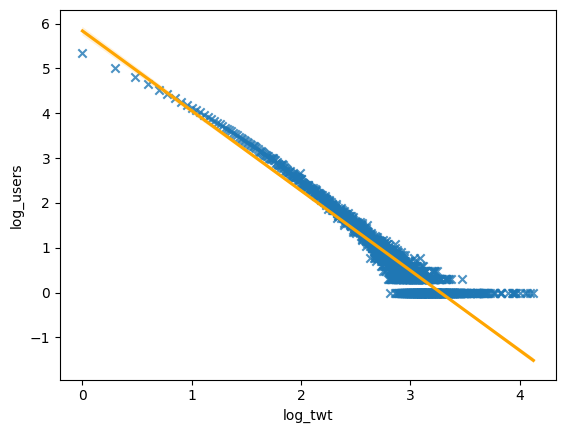

In [26]:
# Drawback with this is that it doesn't allow us to access the lin reg line!
sns.regplot(
    x = twt_df_usr_2['log_twt'] , y = twt_df_usr_2['log_users'] , 
    scatter = True , 
    fit_reg = True , 
    marker = 'x' , 
    line_kws = {'color' : 'orange'}
)

$$
Y = 5.6 -1.666X
\\
Knowing \ that\ Y = log_{10}y \ and\ X = log_{10}x,
\\
y = 10^{5.6}x^{-1.666}
$$

From this preliminary standpoint, these accounts appear to be bots, but more investigation is needed.

### **Question - 2**

In [27]:
twt_df_usr.sort_values('num_twt' , ascending=False).head(5)

,user,num_twt
199506,1402775770481713157,13376
267100,1491316688549253120,12518
736010,954732087235563520,11628
188394,1384110594,11294
27730,1069583615762288642,10087


More investigation is needed to peer into their behaviour. Names, post content and patterns of timestamps may be a good place to start!

In [28]:
def vis_hi_usage(df , users) -> [None]:
    '''
    simple visualization of anomalously voluminous tweeters
    params: df: dataframe; contains user tweets and timestamps
    params: users: list; intended user
    return: no return
    '''
    fig , axes = plt.subplots(len(users) , 1 , figsize = (20, 5))
    for _ , (ax , usr) in enumerate(zip(axes , users)):
        user = str(usr)
        
        df_user = df[df['user'] == user].copy()
        
        df_user['day_hr'] = df_user['day']*100+df_user['hour']
        df_user_2 = df_user.groupby('day_hr').agg(num_tweets = ('tweet_id' , 'nunique')).reset_index()
        df_user_2['day_hr'] = df_user_2['day_hr'].astype('str').str.zfill(4)
        
        ax.plot(df_user_2.day_hr , df_user_2.num_tweets , label = f'User {user}');
        ax.legend(loc = 'right');

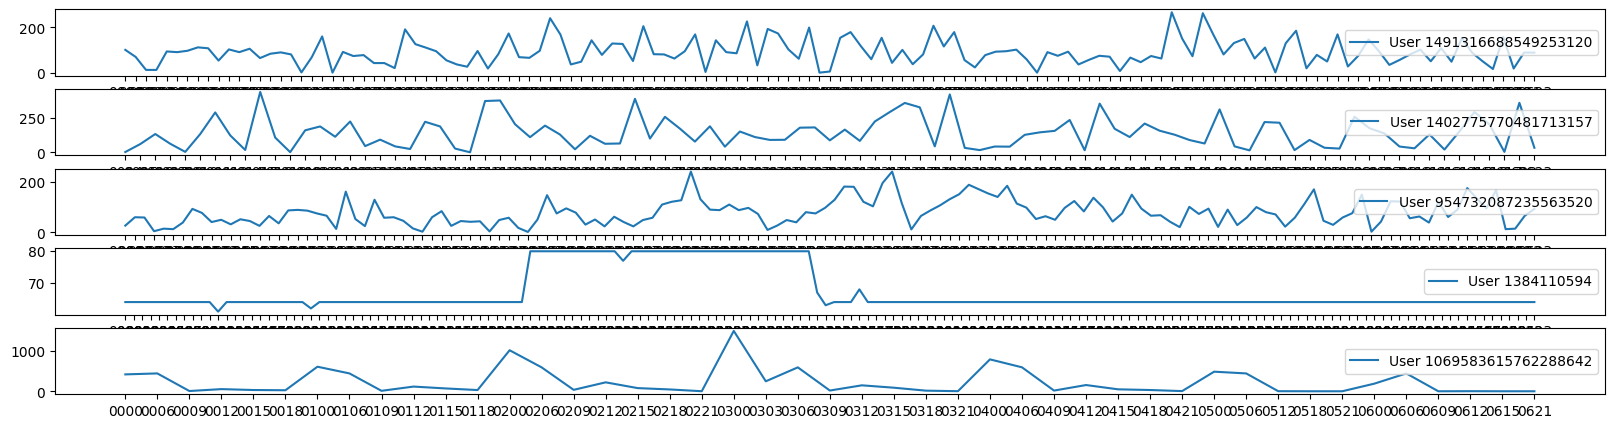

In [29]:
vis_hi_usage(df = twt_df, users = [1491316688549253120,1402775770481713157,954732087235563520,1384110594,1069583615762288642])

No discernable pattern, apart from maybe 1069583615762288642

### **Question-3**

In [30]:
%%time

# Make DF
twt_mentions_df = pd.DataFrame(
    list(zip(user , tweets , mentions , coord , ts_convert)) , 
    columns = ['user' , 'tweets' , 'mentions' , 'coord' , 'ts']
)
# Get rid of null values
twt_mentions_df = twt_mentions_df[twt_mentions_df['tweets']!='None']
# Get rid of duplicates
twt_mentions_df.drop_duplicates(inplace=True)

# Grouping to get top 5 users (in terms of number of mentions)
twt_mentions_df_2 = twt_mentions_df[twt_mentions_df['mentions']!="None"].groupby('mentions').agg(num_mentions = ('mentions' , 'count')).reset_index()
twt_mentions_df_2.sort_values('num_mentions', ascending=False).head(5)

CPU times: total: 1min 8s
Wall time: 1min 8s


,mentions,num_mentions
24406,10228272,15536
1619240,68034431,6610
1219355,2866804900,5460
787568,1503799593405800449,5413
1289919,3131144855,5385


*These highly mentioned accounts are probably:*
1. Celebrities/ Influencers
2. Political Figures
3. Companies/ Groups
_____________
**For example**<br/>
10228272 - YouTube<br/>
68034431 - Recep Tayyip Erdogan (President of Turkey)<br/>
2866804900 - SkylerFleur - Suspended Account<br/>
1503799593405800449 - Student Governing Council IIIT Basar - **QUESTION** Why are a bunch of tweets originating in India?<br/>
3131144855 - BoJo<br/>

In [31]:
twt_mentions_df[twt_mentions_df['mentions'] == '1503799593405800449']

,user,tweets,mentions,coord,ts
6498679,1463710170903580675,1536531096241786881,1503799593405800449,None,2022-06-14 03:08:55.368
6500980,1269455155876921345,1536542182449893376,1503799593405800449,None,2022-06-14 03:52:58.526
6507562,1296293410584715264,1536561198035922944,1503799593405800449,None,2022-06-14 05:08:32.195
6525372,1536550688687529984,1536583678406451200,1503799593405800449,None,2022-06-14 06:37:51.933
6528460,1536565272362078208,1536586488162373637,1503799593405800449,None,2022-06-14 06:49:01.831
...,...,...,...,...,...
10013880,1267823149720068098,1539089862699401216,1503799593405800449,None,2022-06-21 04:36:32.831
10013953,1267823149720068098,1539090071869325312,1503799593405800449,None,2022-06-21 04:37:22.701
10021597,1267823149720068098,1539105860286574592,1503799593405800449,None,2022-06-21 05:40:06.953
10037093,1487327070174998528,1539123273522610177,1503799593405800449,None,2022-06-21 06:49:18.592


In [32]:
twt_mentions_df_3 = twt_mentions_df_2.groupby('num_mentions').agg(users = ('mentions','nunique')).reset_index()
twt_mentions_df_3['log_users'] = np.log10(twt_mentions_df_3['users'])
twt_mentions_df_3['log_mentions'] = np.log10(twt_mentions_df_3['num_mentions'])

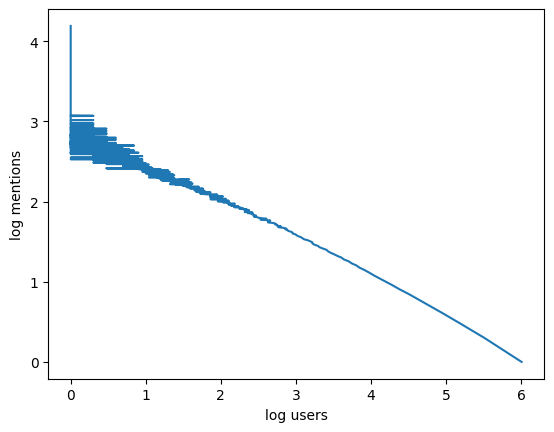

In [33]:
plt.plot(twt_mentions_df_3['log_users'] , twt_mentions_df_3['log_mentions']);
plt.xlabel('log users');
plt.ylabel('log mentions');

### **QUESTION - 4**
Choose 4 countries and compute how often they mention each other. This means you should compute 16 numbers e.g. UK mentions UK, UK mentions
France, France mentions UK etc. Comment on any patterns you observe. [5 marks]

In [3]:
%%time

# Make DF
twt_mentions_df = pd.DataFrame(
    list(zip(user , mentions , tweets , country)) , 
    columns = ['user' , 'mentions' , 'tweet_id' , 'country']
)

twt_mentions_df = twt_mentions_df[twt_mentions_df['tweet_id']!= "None"].drop_duplicates()
print(f'the length of the df is {len(twt_mentions_df)}') # Turn this into an assertion check later!
twt_mentions_df = twt_mentions_df[twt_mentions_df['mentions']!= "None"]

# Use dask to parallelize pandas stuff!
dask_mentions_df = from_pandas(twt_mentions_df, npartitions=8)
del twt_mentions_df , user , mentions , tweets , country , ts , ca , coord

the length of the df is 15033548
CPU times: total: 50.8 s
Wall time: 50.9 s


In [6]:
# Group countries based on who's mentioning whom
mention_join = dask_mentions_df.merge(
    dask_mentions_df , left_on='mentions' , right_on='user' , how = 'inner'
    )[['country_x' , 'country_y']].rename(columns = {'country_x' : 'user_country' , 'country_y' : 'mentioned_country'})

# Split back into user and mentioned cols again 
mention_join['user->mentioned'] = mention_join['user_country'].astype('str')+'-'+mention_join['mentioned_country'].astype('str')

# Group by number of occurences (occr)
mention_join = mention_join.groupby('user->mentioned').agg(occr = ('user->mentioned' , 'count'))

# Compute Cross mentions
x_mentions_df = mention_join.compute()
x_mentions_df.reset_index(inplace=True)
x_mentions_df[['user' , 'mentioned']] = x_mentions_df['user->mentioned'].str.split('-' , expand = True).iloc[: , :2]
x_mentions_df.drop('user->mentioned' , axis = 1 , inplace=True)

In [104]:
# https://public.opendatasoft.com/explore/dataset/countries-territories-taxonomy-mvp-ct-taxonomy-with-hxl-tags1/export/
# https://stefangabos.github.io/world_countries/
# https://www.kaggle.com/datasets/prasertk/country-name-in-different-languages
country_codes = pd.read_csv(
    os.path.join(
        os.getcwd() , 'country name in different languages.csv'
        )
    )

# Let's randomly decide on 4 countries for now.
country_list = ['France' , 'Germany' , 'Spain' , 'Portugal']

# Let's get these countries and the different names they're called by!
restricted_country_names = country_codes[country_codes['en'].isin(country_list)].drop('country_code' , axis = 1)
pivoted_country_names = pd.melt(restricted_country_names, id_vars=['en'], var_name='language', value_name='name')

In [130]:
# Changing Non-English names to English names (for consistency)
x_mentions_df_2 = x_mentions_df.merge(
    pivoted_country_names[['en' , 'name']] , 
    left_on = 'user' , 
    right_on = 'name'
).merge(
    pivoted_country_names[['en' , 'name']] , 
    left_on = 'mentioned' , 
    right_on = 'name'
).rename(
    columns = {'en_x':'user_country' , 'en_y':'mentioned_country'}
)[['occr' , 'user_country' , 'mentioned_country']]

# Restricted to 4 countries
print(f'length before grouping : {len(x_mentions_df_2)}')
print(f'sum of occurence : {x_mentions_df_2.sum().occr}')
print("_"*30)

x_mentions_df_3 = x_mentions_df_2.groupby(['user_country' , 'mentioned_country']).agg(occr = ('occr',np.sum))

# Regrouped
print(f'length before grouping : {len(x_mentions_df_3)}')
print(f'sum of occurence : {x_mentions_df_3.sum().occr}')

length before grouping : 358
sum of occurence : 35524836
______________________________
length before grouping : 16
sum of occurence : 35524836


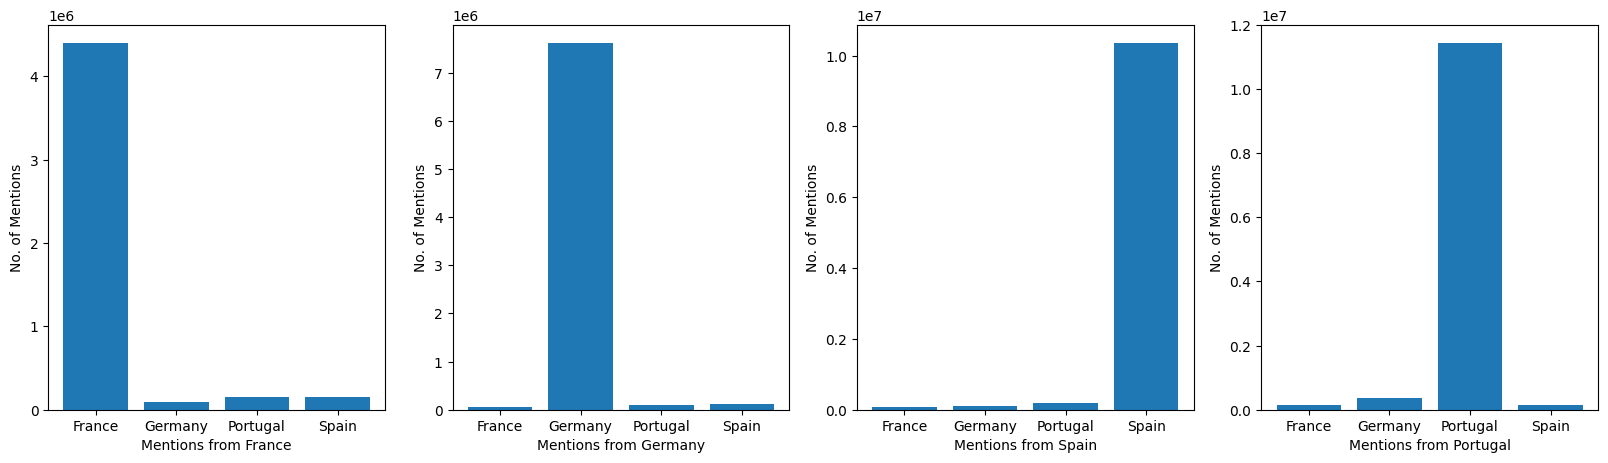

In [190]:
# Graph the number of cross mentions
fig , axes = plt.subplots(1 , len(country_list) , figsize = (20 , 5))

for _ , (ax , user) in enumerate(zip(axes , country_list)):
    df = x_mentions_df_3.loc[user]
    ax.bar(df.index , df.occr);
    ax.set_xlabel(f'Mentions from {user}')
    ax.set_ylabel('No. of Mentions');

# Countries seem to mostly be mentioning themselves

# **03 - MAPPING**
### **QUESTION - 1**

In [12]:
# Use tweets and coordinates to create a mapping dataframe
mapping_df = pd.DataFrame(
    list(zip(tweets , coord)) , columns = ['tweet_id' , 'coordinates']
)

mapping_df = mapping_df[
    (mapping_df['tweet_id']!="None")&
    (mapping_df['coordinates']!="None")
].drop_duplicates()

len(mapping_df)

701961

,tweet_id,coordinates
1,1531772510701748225,"[13.435, 52.481388]"
5,1531772514749366274,"[8.98777778, 44.4975]"
11,1531772517978865665,"[30.52457392, 50.45086087]"
12,1531772518041849858,"[24.03134286, 49.84180882]"
13,1531772519182647296,"[1.893817, 41.545639]"
...,...,...
15040532,1542643935541075976,"[19.0503, 47.4719]"
15040653,1542644089216270336,"[19.02435, 50.263503]"
15040687,1542644126209941504,"[82.6167, 49.9833]"
15040688,1542644126298038272,"[19.05697783, 47.496655]"
